<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Variogram Model  
#### Gator Glaciology Lab, University of Florida



Here we fit a variogram model to the experimental variogram calculated in the 1_Experimental_Variogram.ipynb example. Why fit a parametric variogram model to the experimental variogram? First of all, we need a way to interpolate variance estimates to all lag distances. Second, a variogram must satisfy certain mathematical properties in order to be used in kriging and stochastic simulation. This is covered in the Simple_Kriging.ipynb notebook.

The parameters of a variogram model are the nugget, sill, and range. The nugget or y-intercept represents small scale variability. Some of the nugget effect could be attributed to measurement error. The range is the lag distance where the variogram levels off. This means that two points separated by a lag distance greater than or equal to the range are not spatially correlated. The sill is the maximum variability between two points. When working with data that has been transformed to a standard Gaussian distribution, the sill is approximately 1. 

<img src ="Images/variogram.png" width="400">

We use the SciKit-GStat package to model our variograms (see https://scikit-gstat.readthedocs.io/en/latest/ for more details).

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import GStatSim as gs

## Load and plot data

<function matplotlib.pyplot.show(close=None, block=None)>

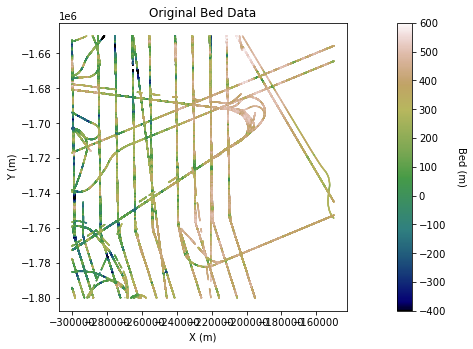

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values due to bad bed picks

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -400, vmax = 600, marker=".", s = 0.5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Normal score transformation and experimental variogram

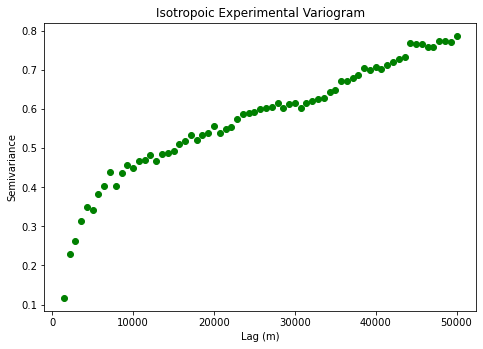

In [3]:
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.plot(xdata,ydata,'og')
plt.title('Isotropoic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size

## Fit variogram model

The variogram parameters are determined automatically using the SciKit-GStat functions:

In [4]:
V1.model = 'exponential' # use exponential variogram model
V1.parameters

[31852.81334061251, 0.702748224072384, 0]

These values are the range, sill, and nugget, respectively. The range describes the correlation length, or distance where two measurements are no longer correlated The sill is variance where the range is reached. The nugget is the variance at a lag distance of zero. 

The nugget effect is often attributed to measurement error (i.e., a non-zero nugget results from measurements with different values at the same location). We have a nugget of zero because our data is gridded. Depending on the analysis, it can be useful to work with non-gridded data in order to investigate the nugget effect and measurement uncertainty. For certain interpolation problems, it is best to have a nugget of zero, while sometimes it is useful to include the nugget.

Now we will create the variogram model. While there are many different variogram model types (see SCiKit-GStat documentation), GlacierStats uses the exponential variogram model, which is the most widely used:

$$
\gamma(\bf{h}) = c [1 - exp^{(-\frac{3\bf{h}^2}{\bf{a}^2})}]
$$


where $\bf{h}$ is the lag distance, $\bf{c}$ is the sill, and $\bf{a}$ is the range. 

In [5]:
# set variogram parameters
vrange = V1.parameters[0]
vsill = V1.parameters[1]
vnugget = V1.parameters[2]

# evaluate models
xi =np.linspace(0, xdata[-1], 1000) 
y_exp = [models.exponential(h, vrange, vsill, vnugget) for h in xi]

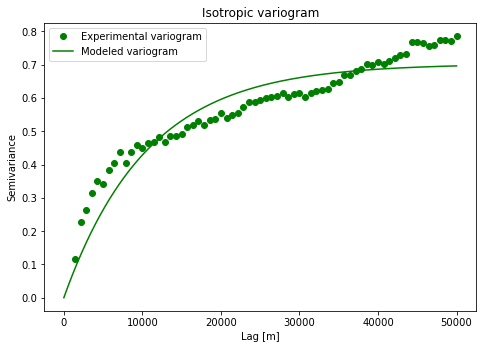

In [6]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata,ydata,'og', label = "Experimental variogram")
plt.plot(xi,y_exp,'-g', label = "Modeled variogram")
plt.title('Isotropic variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='upper left')

For anisotropic variograms, the variogram should be modeled in the major (smoothest) and minor (roughest) directions, which are typicaly orthogonal to each other.

Now that the variogram is modeled, we can use this information to perform interpolations.